In [5]:
'''
Manager Matrix: Insights from 13F Filings on Stocks, Crypto, and Cannabis

'''

'Manager Matrix: Insights from 13F Filings on Stocks, Crypto, and Cannabis\n'

In [ ]:
'''
Questions1: What are the most popular stocks?
'''

In [1]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import warnings
import sys
!{sys.executable} -m pip install matplotlib-venn
from matplotlib_venn import venn2

In [2]:
#Import the csv files for 2024Q1
df1_cov = pd.read_csv("/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/2024q1_form13f/COVERPAGE.tsv", sep='\t')
df1_sub = pd.read_csv("/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/2024q1_form13f/SUBMISSION.tsv", sep='\t')
df1_info = pd.read_csv("/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/2024q1_form13f/INFOTABLE.tsv", sep='\t',
                       usecols=['ACCESSION_NUMBER','INFOTABLE_SK','NAMEOFISSUER','NAMEOFISSUER',
                                          'TITLEOFCLASS','CUSIP','VALUE','SSHPRNAMT','SSHPRNAMTTYPE'],
                          dtype={'ACCESSION_NUMBER':'string','INFOTABLE_SK':'Int32','NAMEOFISSUER':'string',
                                          'TITLEOFCLASS':'string','CUSIP':'string','FIGI':'float','VALUE':'Int64','SSHPRNAMT':'Int32','SSHPRNAMTTYPE':'string'})
    

In [3]:
# Merge cover page, info page, and submission page for Q1 2024
df1_com=df1_cov.loc[:,['ACCESSION_NUMBER', 'REPORTCALENDARORQUARTER', 'FILINGMANAGER_NAME','ISAMENDMENT','AMENDMENTTYPE']].merge(df1_info, how='right', on ='ACCESSION_NUMBER')
df1_com=df1_sub.loc[:,['ACCESSION_NUMBER','CIK','FILING_DATE', 'SUBMISSIONTYPE']].merge(df1_com, how='right', on ='ACCESSION_NUMBER')


In [4]:
# Identify the top 15 most popular stocks
grouped_stats = df1_com.groupby(['NAMEOFISSUER'], as_index=False).agg(
    total_value=('VALUE','sum'),
    total_investors=('NAMEOFISSUER','count'),
    Num_share=('SSHPRNAMT','sum'))

top_pop_10_methods1=grouped_stats.sort_values(by='total_value',ascending=False).head(50).merge(
    grouped_stats.sort_values(by='total_investors',ascending=False).head(50),
    how='inner',on='NAMEOFISSUER').head(15)
top_pop_10_methods1=top_pop_10_methods1.loc[~((top_pop_10_methods1['NAMEOFISSUER'] 
                                               == 'SPDR S&P 500 ETF TR') 
                                              | (top_pop_10_methods1['NAMEOFISSUER']
                                                 == 'ISHARES TR')
                                              |(top_pop_10_methods1['NAMEOFISSUER'] 
                                                == 'VANGUARD INDEX FDS'))]


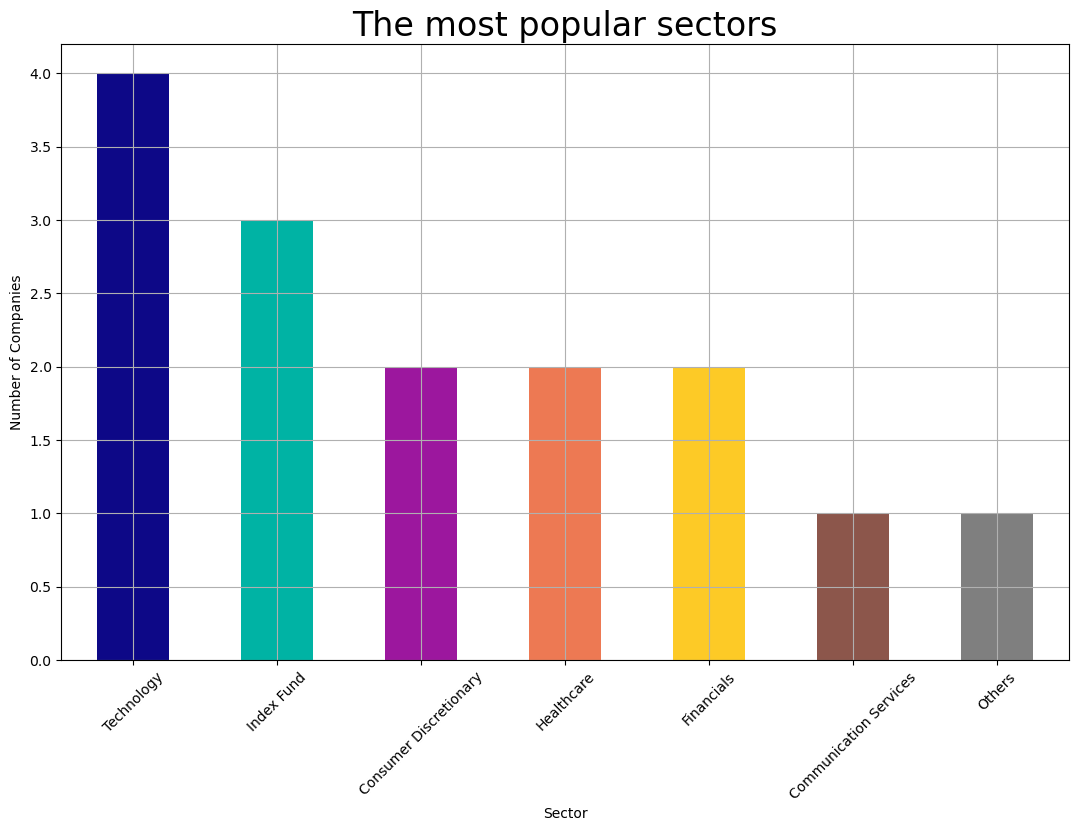

In [5]:
# Generate a bar chart for the most popular sectors
# Create a DataFrame with company names and their sectors
data = {
    'Company': ['MICROSOFT CORP', 'APPLE INC', 'ISHARES TR', 'ALPHABET INC', 
                'AMAZON COM INC', 'SPDR S&P 500 ETF TR', 'NVIDIA CORPORATION', 
                'META PLATFORMS INC', 'TESLA INC', 'VANGUARD INDEX FDS', 
                'UNITEDHEALTH GROUP INC', 'VISA INC', 'JPMORGAN CHASE & CO', 
                'BERKSHIRE HATHAWAY INC DEL', 'JOHNSON & JOHNSON'],
    'Sector': ['Technology', 'Technology', 'Index Fund', 'Technology', 
               'Consumer Discretionary', 'Index Fund', 'Technology', 
               'Communication Services', 'Consumer Discretionary', 'Index Fund', 
               'Healthcare', 'Others', 'Financials', 'Financials', 'Healthcare']}

df = pd.DataFrame(data)

# Count the number of companies per sector
sector_counts = df['Sector'].value_counts()

# Define colors for each sector
colors = ['#0d0887', '#00b3a4','#9c179e', '#ed7953', '#fdca26', '#8c564b','#7f7f7f']

# Plotting
plt.figure(figsize=(13, 8))
sector_counts.plot(kind='bar', color=colors[:len(sector_counts)])
plt.title('The most popular sectors',fontsize=24)
plt.xlabel('Sector')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [25]:
# Create a treemap for the top 12 most popular individual stocks
# Provided color list
color_list = ['#0d0887', '#0d0887','#0d0887', '#9c179e','#0d0887', '#8c564b','#9c179e', '#ed7953','#fdca26','#fdca26','#7f7f7f', '#ed7953']


# Sort your DataFrame (if not already sorted) and reset the index
top_pop_10_methods_sorted = top_pop_10_methods1.sort_values(by='total_value_x', 
                                                            ascending=False).reset_index(drop=True)

# Convert total_value_x to millions
top_pop_10_methods_sorted['total_value_x'] = (top_pop_10_methods_sorted['total_value_x'] / 
                                              1000000).round().astype(int)

# Ensure we have a color for each stock by cycling through the color list
num_stocks = len(top_pop_10_methods_sorted)
colors_cycle = np.tile(color_list, int(np.ceil(num_stocks / len(color_list))))[:num_stocks]

# Treemap
fig = go.Figure(go.Treemap(
    labels=top_pop_10_methods_sorted['NAMEOFISSUER'],
    parents=[""] * len(top_pop_10_methods_sorted),  # Top level
    values=top_pop_10_methods_sorted['total_value_x'],
    textinfo="label+value+percent parent",
    branchvalues="total",
    textfont=dict(size=20, color='white'),
    marker=dict(colors=colors_cycle)  # Use cycled colors
))

fig.update_layout(
    title_text='Top 12 Individual Stocks by Popularity ($MM)',
    title_x=0.5,
    title_font=dict(size=24),
    width=900,
    height=700
)

fig.show()


In [12]:
'''
Question2: What are the top three asset managers and how do their investment strategies compare?

'''

'\nQuestion2: What are the top three asset managers and how do their investment strategies compare?\n\n'

In [23]:
# Retrieve all CUSIPs for the top 12 most popular stocks.


unique_cusip = {}
for stock in top_pop_10_methods1.NAMEOFISSUER.tolist():
    first_word = stock.split(' ')[0]
    unique_cusip[stock] = df1_com[df1_com['NAMEOFISSUER'].str.contains(first_word, case=False, na=False)].CUSIP.unique().tolist()

# unique_cusip.keys()
# del unique_cusip['ISHARES TR']
# del unique_cusip['SPDR S&P 500 ETF TR']
# del unique_cusip['VANGUARD INDEX FDS']

#flatteb the the CUSIP list
flattened_set = {identifier for sublist in unique_cusip.values() for identifier in sublist}
flattened_list = list(flattened_set)
flattened_list

['59100U908',
 '48128B549',
 '828363901',
 '46625H365',
 '48128B523',
 '023135AP1',
 '92876C839',
 '46637K687',
 '03783C100',
 '591236203',
 '172908105',
 '68276W400',
 '194162103',
 '4812A1373',
 '808524607',
 '020764906',
 '26922A719',
 '88160R101',
 '53656F417',
 '46641Q761',
 '594918954',
 '59124U905',
 'L02235106',
 '846700702',
 '59134N104',
 '46641U382',
 '59491810R',
 '591407101',
 '957289101',
 '30303M102',
 '617901947',
 '46641q217',
 '22945L402',
 '46654Q815',
 '38259P508',
 '48128WTZ8',
 '4812C0381',
 '88160r101',
 '91324P952',
 '87261Y956',
 '67066G954',
 '92826C959',
 '46641Q142',
 '941872103',
 '72303K207',
 '037833100',
 '580135101',
 '201723953',
 '46641Q159',
 '46641Q191',
 'G5568L117',
 '489170900',
 '27888N956',
 '911312106',
 '46641Q449',
 'G51502905',
 '37960A834',
 '02079K107',
 '594918904',
 '46654Q781',
 '92189H805',
 '113809107',
 '92537N108',
 '084597202',
 '92826C839',
 '884768102',
 '02079K305',
 '464287408',
 '29877A205',
 '479167108',
 'G3937M106',
 '4812

In [13]:
# Import and concatenate all 13F ZIP files from 2014 to 2024, filtering for relevant columns for top 15 popular stocks 

start_year = 2014
end_year = 2023
quarters = [f"{year}q{quarter}" for year in range(start_year, end_year + 1) for quarter in range(1, 5)]
quarters.append("2024q1")


merged_dfs=[]


top_15_stocks=flattened_list

for quarter in quarters:
    df_cov = pd.read_csv(f"/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/{quarter}_form13f/COVERPAGE.tsv", sep='\t',
                         usecols=['ACCESSION_NUMBER', 'REPORTCALENDARORQUARTER', 'FILINGMANAGER_NAME','ISAMENDMENT','AMENDMENTTYPE'])
    df_sub = pd.read_csv(f"/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/{quarter}_form13f/SUBMISSION.tsv", sep='\t',
                         usecols=['ACCESSION_NUMBER','CIK','FILING_DATE', 'SUBMISSIONTYPE'])
    df_info = pd.read_csv(f"/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/{quarter}_form13f/INFOTABLE.tsv", 
                          sep='\t',usecols=['ACCESSION_NUMBER','INFOTABLE_SK','NAMEOFISSUER','NAMEOFISSUER',
                                          'TITLEOFCLASS','CUSIP','VALUE','SSHPRNAMT','SSHPRNAMTTYPE'],
                          dtype={'ACCESSION_NUMBER':'string','INFOTABLE_SK':'Int32','NAMEOFISSUER':'string','NAMEOFISSUER':'string',
                                          'TITLEOFCLASS':'string','CUSIP':'string','FIGI':'float','VALUE':'Int64','SSHPRNAMT':'Int32','SSHPRNAMTTYPE':'string'})


    
    #merge coverpage and info q1 2024
    df_com=df_cov.merge(df_info, how='right', on ='ACCESSION_NUMBER')
    df_com=df_sub.merge(df_com, how='right', on ='ACCESSION_NUMBER')
    df_com=df_com.loc[(df_com['CUSIP'].isin(top_15_stocks))]
    #add 
    df_com['filing_quarter']=quarter
    merged_dfs.append(df_com)

        
#concat q1 2024 and q4 2023
df_com=pd.concat(merged_dfs)
del merged_dfs
        

In [ ]:
#save the merged and filtered data as a pickle file 
df_com.to_pickle('/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/combine_data_COM_Top20pop.pkl')

In [14]:
# Use this pickle file to avoid re-running the file merging process
df_com_top=pd.read_pickle('/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/combine_data_COM_Top20pop.pkl')

In [15]:
# Initialize an empty list to hold the filtered DataFrames
filtered_dfs = []

# Iterate over each stock name in top_pop_10_methods1.NAMEOFISSUER
for stock in top_pop_10_methods1.NAMEOFISSUER.tolist():
    # Extract the first word of the NAMEOFISSUER
    first_word = stock.split(' ')[0]
    
    # Filter df1_com to only include rows where NAMEOFISSUER contains the first word
    filtered_df = df_com_top[df_com_top['NAMEOFISSUER'].str.contains(first_word, case=False, na=False)]
    
     # Assign the first word as a new column value safely using .loc.
    filtered_df.loc[:, 'new_stock_name'] = first_word
    
    # Append the filtered DataFrame to the list
    filtered_dfs.append(filtered_df)
    
# Concatenate all filtered DataFrames into one and remove duplicates   
df_com_filtered = pd.concat(filtered_dfs).drop_duplicates()


/var/folders/ww/8cnk8cbj1j56c7zdw6nvqfjc0000gn/T/ipykernel_41611/4286152512.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ww/8cnk8cbj1j56c7zdw6nvqfjc0000gn/T/ipykernel_41611/4286152512.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ww/8cnk8cbj1j56c7zdw6nvqfjc0000gn/T/ipykernel_41611/4286152512.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [16]:
# Adjust the function to correctly replace the quarter with the accurate starting month
def convert_quarter_to_accurate_date(quarter_str):
    year, quarter = quarter_str.split('q')
    # Correctly map the quarter to the starting month of the quarter
    if quarter == '1':
        month = 1  # Q1 starts in January
    elif quarter == '2':
        month = 4  # Q2 starts in April
    elif quarter == '3':
        month = 7  # Q3 starts in July
    else:
        month = 10  # Q4 starts in October
    return f"{month}/1/{year}"

In [17]:
#top three manager holding graphic1

df_com_3=df_com_filtered.copy()
df_com_3 = df_com_3.loc[df_com_3['CIK'].isin([93751, 1364742, 102909])]


import numpy as np

# Improved approach using np.where to handle multiple conditions
df_com_3['new_manager_name'] = np.where(
    df_com_3['FILINGMANAGER_NAME'].str.contains('Vanguard', case=False, na=False),
    'Vanguard',
    np.where(
        df_com_3['FILINGMANAGER_NAME'].str.contains('State', case=False, na=False),
        'State Street',
        np.where(
            df_com_3['FILINGMANAGER_NAME'].str.contains('Black', case=False, na=False),
            'Black Rock',
            df_com_3['FILINGMANAGER_NAME']  # Default to the original if none of the conditions are met
        )
    )
)


# Apply the corrected conversion function to the 'filing_quarter' column
df_com_3['filing_quarter'] = df_com_3['filing_quarter'].apply(convert_quarter_to_accurate_date)
df_com_3['filing_quarter']=pd.to_datetime(df_com_3['filing_quarter'])


# Data preparation steps remain similar
df_com_3['SSHPRNAMT'] = pd.to_numeric(df_com_3['SSHPRNAMT'], errors='coerce').fillna(0).astype(float)
df_com_3['CIK'] = df_com_3['CIK'].astype(str)
grouped_data = df_com_3.groupby(['filing_quarter', 'CIK', 'new_manager_name'])['SSHPRNAMT'].sum().reset_index()
top_managers_each_quarter = grouped_data.reset_index(drop=True)#.groupby('filing_quarter').apply(lambda x: x.nlargest(5, 'SSHPRNAMT')).reset_index(drop=True)
top_managers_each_quarter['Manager_Info'] = top_managers_each_quarter['CIK'] + ' - ' + top_managers_each_quarter['new_manager_name']


# Create a stacked area chart using Plotly Express
fig = px.area(top_managers_each_quarter, x='filing_quarter', y='SSHPRNAMT', color='Manager_Info',
              labels={'SSHPRNAMT': 'Total Number of Shares Held', 'filing_quarter': 'Filing Quarter', 'Manager_Info': 'CIK - Manager Name'},
              title='Top 5 Managers by Total Number of Shares Held Each Quarter')


# Ensure layout updates and show the figure
fig.update_layout(xaxis_title='Filing Quarter', yaxis_title='Total Number of Shares Held', yaxis_type='log')
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [18]:
#top three manager holding graphic2
df_com_4=df_com_filtered.copy()
df_com_4 = df_com_4.loc[df_com_4['CIK'].isin([93751, 1364742, 102909])]

# Improved approach using np.where to handle multiple conditions
df_com_4['new_manager_name'] = np.where(
    df_com_4['FILINGMANAGER_NAME'].str.contains('Vanguard', case=False, na=False),
    'Vanguard',
    np.where(
        df_com_4['FILINGMANAGER_NAME'].str.contains('State', case=False, na=False),
        'State Street',
        np.where(
            df_com_4['FILINGMANAGER_NAME'].str.contains('Black', case=False, na=False),
            'Black Rock',
            df_com_4['FILINGMANAGER_NAME']  # Default to the original if none of the conditions are met
        )
    )
)

# Apply the corrected conversion function to the 'filing_quarter' column
df_com_4['filing_quarter'] = df_com_4['filing_quarter'].apply(convert_quarter_to_accurate_date)
df_com_4['filing_quarter']=pd.to_datetime(df_com_4['filing_quarter'])


# Data preparation steps remain similar
df_com_4['SSHPRNAMT'] = pd.to_numeric(df_com_4['SSHPRNAMT'], errors='coerce').fillna(0).astype(float)
df_com_4['CIK'] = df_com_4['CIK'].astype(str)
grouped_data =df_com_4.groupby(['filing_quarter', 'CIK', 'new_manager_name'])['SSHPRNAMT'].sum().reset_index()
top_managers_each_quarter = grouped_data.reset_index(drop=True)#.groupby('filing_quarter').apply(lambda x: x.nlargest(5, 'SSHPRNAMT')).reset_index(drop=True)
top_managers_each_quarter['Manager_Info'] = top_managers_each_quarter['CIK'] + ' - ' + top_managers_each_quarter['new_manager_name']

fig = px.bar(top_managers_each_quarter, x='filing_quarter', y='SSHPRNAMT', color='Manager_Info',
             labels={'SSHPRNAMT': 'Total Number of Shares Held', 'filing_quarter': 'Filing Quarter', 'Manager_Info': 'CIK - Manager Name'},
             title='Total Number of Shares Held by Top Managers Each Quarter')

# Ensure layout updates and show the figure
fig.update_layout(xaxis_title='Filing Quarter', yaxis_title='Total Number of Shares Held', yaxis_type='log')
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [19]:
#Vanguard holdings 

df_com_pop20_vang=df_com_filtered.copy()
df_com_pop20_vang=df_com_pop20_vang[df_com_pop20_vang['FILINGMANAGER_NAME'].str.contains("VANGUARD", case=False, na=False)]
df_com_pop20_vang = df_com_pop20_vang.loc[df_com_pop20_vang['CIK'] == 102909]

df_com_pop20_vang = df_com_pop20_vang.groupby(['new_stock_name', 'filing_quarter']).agg(
    total_num=('SSHPRNAMT', 'sum'),  # Sum of VALUE for each group
    stock_name=('new_stock_name', lambda x: x.iloc[0])  # First NAMEOFISSUER encountered for each group
).reset_index()
# Reload the provided file to reset the changes made earlier
df_com_pop20_vang


# Apply the corrected conversion function to the 'filing_quarter' column
df_com_pop20_vang['filing_quarter'] = df_com_pop20_vang['filing_quarter'].apply(convert_quarter_to_accurate_date)

# Display the first few rows to confirm the change
#df_com_pop20_vang
# Suppress specific future warnings from plotly
warnings.filterwarnings("ignore", category=FutureWarning, module="_plotly_utils.basevalidators")

# Assuming df_com_pop20_vang is your DataFrame
latest_df = df_com_pop20_vang

# Convert 'filing_quarter' to datetime format for Plotly
latest_df['filing_quarter'] = pd.to_datetime(latest_df['filing_quarter'])



# Create the stacked chart with Plotly Express
fig = px.area(latest_df, x='filing_quarter', y='total_num', color='stock_name',
              labels={'total_value': 'Total Value', 'filing_quarter': 'Filing Quarter', 'stock_name': 'Stock Name'},
              title='Total Number of Stocks Over Time')

# Display the figure
fig.show()

In [20]:
#state street holdings 
df_com_STT=df_com_filtered.copy()
df_com_STT = df_com_STT.loc[df_com_STT['CIK'] == 93751]

df_com_STT = df_com_STT.groupby(['new_stock_name', 'filing_quarter']).agg(
    total_num=('SSHPRNAMT', 'sum'),  # Sum of VALUE for each group
    stock_name=('new_stock_name', lambda x: x.iloc[0])  # First NAMEOFISSUER encountered for each group
).reset_index()

# Apply the corrected conversion function to the 'filing_quarter' column
df_com_STT['filing_quarter'] =df_com_STT['filing_quarter'].apply(convert_quarter_to_accurate_date)

# Display the first few rows to confirm the change
#df_com_pop20_vang
# Suppress specific future warnings from plotly
warnings.filterwarnings("ignore", category=FutureWarning, module="_plotly_utils.basevalidators")

# Assuming df_com_pop20_vang is your DataFrame
latest_df = df_com_STT

# Convert 'filing_quarter' to datetime format for Plotly
latest_df['filing_quarter'] = pd.to_datetime(latest_df['filing_quarter'])



# Create the stacked chart with Plotly Express
fig = px.area(latest_df, x='filing_quarter', y='total_num', color='stock_name',
              labels={'total_value': 'Total Value', 'filing_quarter': 'Filing Quarter', 'stock_name': 'Stock Name'},
              title='Total Number of Stocks Over Time')

# Display the figure
fig.show()


In [21]:
#Blackrock holdings 

df_com_blk=df_com_filtered.copy()

df_com_blk = df_com_blk.loc[df_com_blk['CIK'] == 1364742]

df_com_blk = df_com_blk.groupby(['new_stock_name', 'filing_quarter']).agg(
    total_num=('SSHPRNAMT', 'sum'),  # Sum of VALUE for each group
    stock_name=('new_stock_name', lambda x: x.iloc[0])  # First NAMEOFISSUER encountered for each group
).reset_index()


# Apply the corrected conversion function to the 'filing_quarter' column
df_com_blk['filing_quarter'] = df_com_blk['filing_quarter'].apply(convert_quarter_to_accurate_date)

# Display the first few rows to confirm the change
#df_com_pop20_vang
# Suppress specific future warnings from plotly
warnings.filterwarnings("ignore", category=FutureWarning, module="_plotly_utils.basevalidators")

# Assuming df_com_pop20_vang is your DataFrame
latest_df = df_com_blk

# Convert 'filing_quarter' to datetime format for Plotly
latest_df['filing_quarter'] = pd.to_datetime(latest_df['filing_quarter'])



# Create the stacked chart with Plotly Express
fig = px.area(latest_df, x='filing_quarter', y='total_num', color='stock_name',
              labels={'total_num': 'total_num', 'filing_quarter': 'Filing Quarter', 'stock_name': 'Stock Name'},
              title='Total Number of Stocks Over Time')

# Display the figure
fig.show()

/var/folders/ww/8cnk8cbj1j56c7zdw6nvqfjc0000gn/T/ipykernel_29240/3249958366.py:7: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



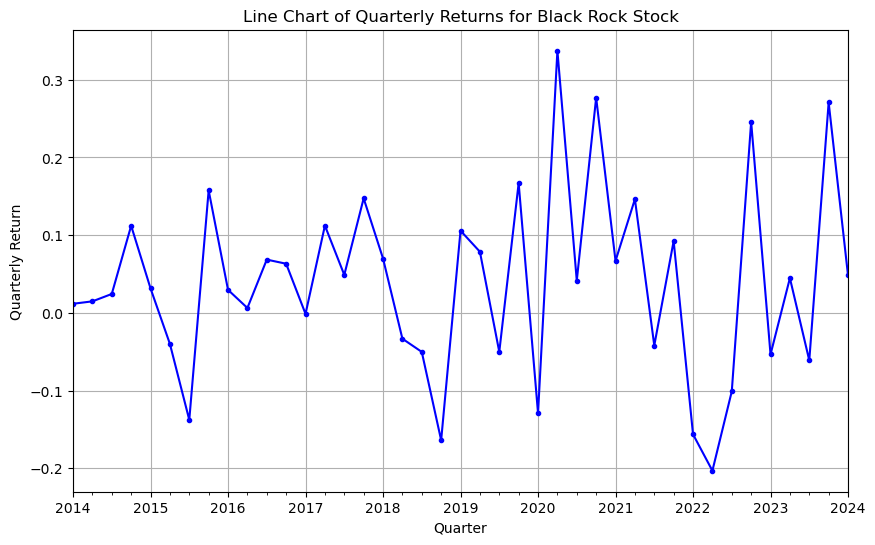

In [31]:
#Line Chart of Quarterly Returns for Black Rock Stock

# Load the CSV file
data = pd.read_csv('/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/BLK.csv')

# Convert the 'Date' column to datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Resample the data to get the adjusted close price at the start and end of each quarter
quarterly_prices = data['Adj Close'].resample('Q').ohlc()[['open', 'close']]

# Calculate the quarterly returns
quarterly_returns = (quarterly_prices['close'] - quarterly_prices['open']) / quarterly_prices['open']

# Plotting the quarterly returns as a line chart
plt.figure(figsize=(10, 6))
quarterly_returns.plot(kind='line', marker='.', linestyle='-', color='blue')
plt.title('Line Chart of Quarterly Returns for Black Rock Stock')
plt.xlabel('Quarter')
plt.ylabel('Quarterly Return')
plt.grid(True)
plt.show()

/var/folders/ww/8cnk8cbj1j56c7zdw6nvqfjc0000gn/T/ipykernel_29240/931605913.py:9: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



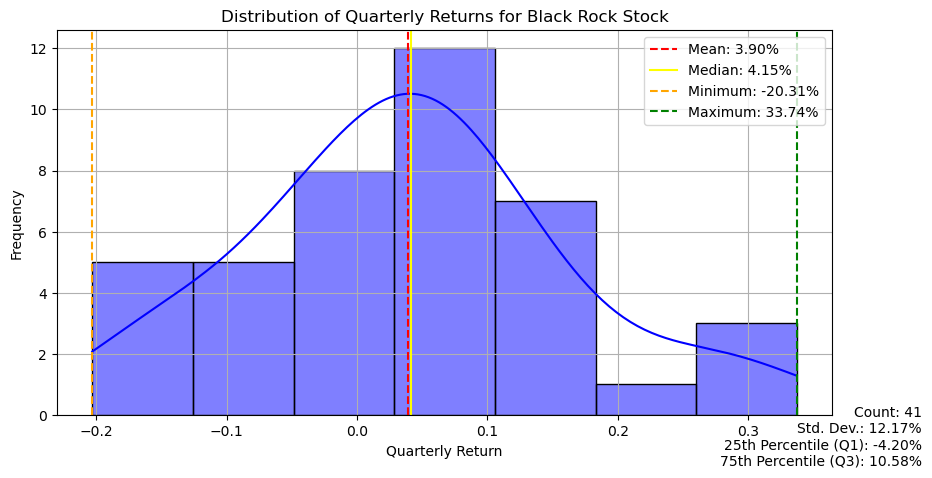

In [38]:
#Distribution of Quarterly Returns for BlackRock Stock


# Load the CSV file
data = pd.read_csv('/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/BLK.csv')


# Convert the 'Date' column to datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Resample the data to get the adjusted close price at the start and end of each quarter
quarterly_prices = data['Adj Close'].resample('Q').ohlc()[['open', 'close']]

# Calculate the quarterly returns
quarterly_returns = (quarterly_prices['close'] - quarterly_prices['open']) / quarterly_prices['open']

# Creating a detailed plot with statistical annotations for the quarterly returns
plt.figure(figsize=(10, 5))
sns.histplot(quarterly_returns, kde=True, color='blue')
plt.title('Distribution of Quarterly Returns for Black Rock Stock')
plt.xlabel('Quarterly Return')
plt.ylabel('Frequency')
plt.grid(True)

# Adding statistical annotations
mean = quarterly_returns.mean()
median = quarterly_returns.median()
minimum = quarterly_returns.min()
maximum = quarterly_returns.max()
std_dev = quarterly_returns.std()
q1 = quarterly_returns.quantile(0.25)
q3 = quarterly_returns.quantile(0.75)
count = quarterly_returns.count()

plt.axvline(x=mean, color='red', linestyle='--', label=f'Mean: {mean:.2%}')
plt.axvline(x=median, color='yellow', linestyle='-', label=f'Median: {median:.2%}')
plt.axvline(x=minimum, color='orange', linestyle='--', label=f'Minimum: {minimum:.2%}')
plt.axvline(x=maximum, color='green', linestyle='--', label=f'Maximum: {maximum:.2%}')
plt.legend()

# Displaying additional statistics
plt.figtext(0.99, 0.01, 
            f'Count: {count}\nStd. Dev.: {std_dev:.2%}\n25th Percentile (Q1): {q1:.2%}\n75th Percentile (Q3): {q3:.2%}', 
            horizontalalignment='right')

plt.show()

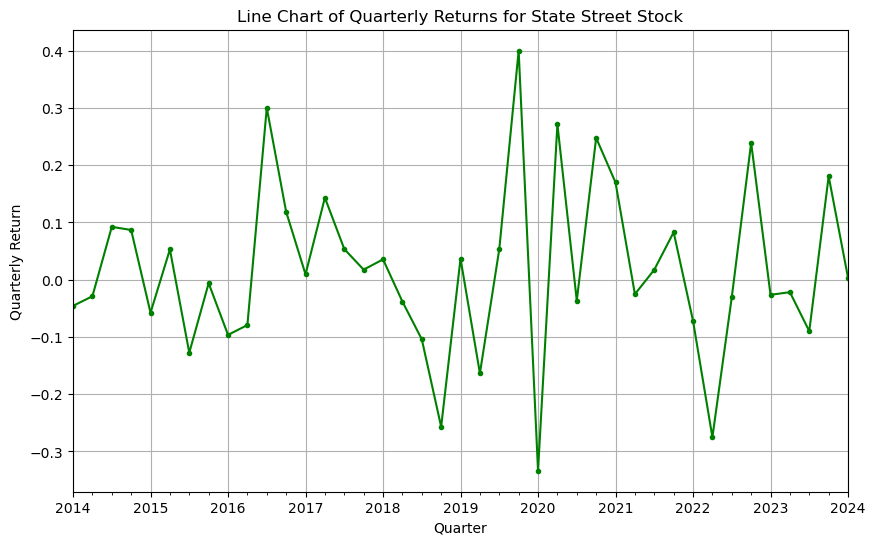

In [36]:
#Line Chart of Quarterly Returns for State Street Stock

# Load the CSV file
data = pd.read_csv('/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/STT.csv')

# Convert the 'Date' column to datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Resample the data to get the adjusted close price at the start and end of each quarter
quarterly_prices = data['Adj Close'].resample('Q').ohlc()[['open', 'close']]

# Calculate the quarterly returns
quarterly_returns = (quarterly_prices['close'] - quarterly_prices['open']) / quarterly_prices['open']

# Plotting the quarterly returns as a line chart
plt.figure(figsize=(10, 6))
quarterly_returns.plot(kind='line', marker='.', linestyle='-', color='Green')
plt.title('Line Chart of Quarterly Returns for State Street Stock')
plt.xlabel('Quarter')
plt.ylabel('Quarterly Return')
plt.grid(True)
plt.show()

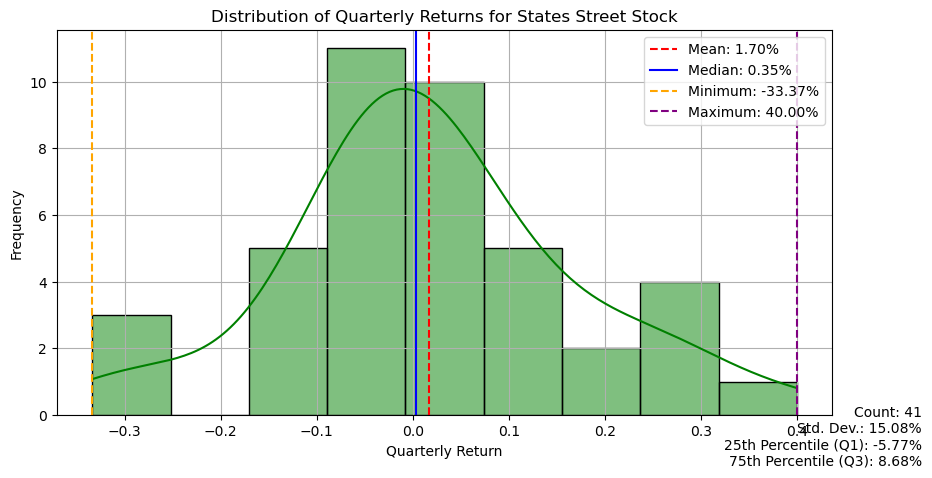

In [34]:
#Distribution of Quarterly Returns for StatesStreet Stock

# Calculate the quarterly returns
quarterly_returns = (quarterly_prices['close'] - quarterly_prices['open']) / quarterly_prices['open']

# Creating a detailed plot with statistical annotations for the quarterly returns
plt.figure(figsize=(10, 5))
sns.histplot(quarterly_returns, kde=True, color='Green')
plt.title('Distribution of Quarterly Returns for States Street Stock')
plt.xlabel('Quarterly Return')
plt.ylabel('Frequency')
plt.grid(True)

# Adding statistical annotations
mean = quarterly_returns.mean()
median = quarterly_returns.median()
minimum = quarterly_returns.min()
maximum = quarterly_returns.max()
std_dev = quarterly_returns.std()
q1 = quarterly_returns.quantile(0.25)
q3 = quarterly_returns.quantile(0.75)
count = quarterly_returns.count()

plt.axvline(x=mean, color='red', linestyle='--', label=f'Mean: {mean:.2%}')
plt.axvline(x=median, color='Blue', linestyle='-', label=f'Median: {median:.2%}')
plt.axvline(x=minimum, color='orange', linestyle='--', label=f'Minimum: {minimum:.2%}')
plt.axvline(x=maximum, color='purple', linestyle='--', label=f'Maximum: {maximum:.2%}')
plt.legend()

# Displaying additional statistics
plt.figtext(0.99, 0.01, 
            f'Count: {count}\nStd. Dev.: {std_dev:.2%}\n25th Percentile (Q1): {q1:.2%}\n75th Percentile (Q3): {q3:.2%}', 
            horizontalalignment='right')

plt.show()


In [51]:
# Merge State Street stock data from Yahoo Finance with 13F filings 

# Load the combined dataframe
df_correlation2 = df_com_top.copy()
df_correlation2 = df_correlation2.loc[df_correlation2['CIK'] == 93751]
df_correlation2 = df_correlation2.groupby(['FILINGMANAGER_NAME', 'filing_quarter']).agg(
    total_value=('VALUE', 'sum'),  # Sum of VALUE for each group
    total_number=('SSHPRNAMT', 'sum'), 
).reset_index()

# Function to convert quarter string to end of quarter date
def convert_quarter_to_accurate_date(quarter_str):
    year, quarter = quarter_str.split('q')
    if quarter == '1':
        month = 3  # Q1 ends in March
        day = 31
    elif quarter == '2':
        month = 6  # Q2 ends in June
        day = 30
    elif quarter == '3':
        month = 9  # Q3 ends in September
        day = 30
    else:
        month = 12  # Q4 ends in December
        day = 31
    return f"{year}-{month}-{day}"

df_correlation2['filing_quarter'] = df_correlation2['filing_quarter'].apply(convert_quarter_to_accurate_date)
df_correlation2['filing_quarter'] = pd.to_datetime(df_correlation2['filing_quarter'])

# Assuming the STT.csv file has been uploaded and is accessible
data = pd.read_csv('/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/STT.csv')  # Update the path as necessary
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Resample the data to get the adjusted close price at the end of each quarter
quarterly_prices_STT = data['Adj Close'].resample('Q').ohlc()[['open', 'close']]
quarterly_prices_STT['Quarterly Return'] = (quarterly_prices_STT['close'] - quarterly_prices_STT['open']) / quarterly_prices_STT['open']
quarterly_prices_STT = quarterly_prices_STT.reset_index()
quarterly_prices_STT.rename(columns={'close': 'Quarterly Closing Price', 'Date': 'filing_quarter'}, inplace=True)

# Merging the quarterly stock prices and returns with the df_correlation2 DataFrame
df_statestreet_correlation_merge = pd.merge(df_correlation2, quarterly_prices_STT[['filing_quarter', 'Quarterly Closing Price', 'Quarterly Return']],
                                            on='filing_quarter', how='left')

# Calculate the percentage change for the specified columns
df_statestreet_correlation_merge['Change in Quarterly Closing Price'] = df_statestreet_correlation_merge['Quarterly Closing Price'].pct_change()
df_statestreet_correlation_merge['Change in Total Value'] = df_statestreet_correlation_merge['total_value'].pct_change()
df_statestreet_correlation_merge['Change in Total Number'] = df_statestreet_correlation_merge['total_number'].pct_change()

# Display the merged DataFrame
df_statestreet_correlation_merge.head()

,FILINGMANAGER_NAME,filing_quarter,total_value,total_number,Quarterly Closing Price,Quarterly Return,Change in Quarterly Closing Price,Change in Total Value,Change in Total Number
0,STATE STREET CORP,2015-06-30,176544667,1926520702,60.478806,0.052865,NaN,<NA>,<NA>
1,STATE STREET CORP,2015-09-30,124324869,1511531894,53.061092,-0.127522,-0.122650,-0.295788,-0.215408
2,STATE STREET CORP,2015-12-31,123345108,1514286377,52.654659,-0.006181,-0.007660,-0.007881,0.001822
3,STATE STREET CORP,2016-03-31,182556757,1857408540,46.705353,-0.096375,-0.112987,0.480049,0.22659
4,STATE STREET CORP,2016-06-30,368714908,3710161498,43.321339,-0.079220,-0.072455,1.019728,0.997494


In [52]:
''' 
Calculate the correlation between the total number of shares from 13F filings for State Street
and State Street's stock data from Yahoo Finance, adjusting for quarterly shifts to assess if 
the correlation strengthens.
'''
data_stt_new=df_statestreet_correlation_merge.copy()
# Trying different shifts on 'total_number' and calculating the correlation with 'Quarterly Closing Price'
shift_correlations_new = {}
for i in range(-8, 9):  # Check from 8 quarters back to 8 quarters forward
    shifted_col = data_stt_new['total_number'].shift(i)
    correlation = shifted_col.corr(data_stt_new['Quarterly Closing Price'])
    shift_correlations_new[i] = correlation

# Finding the shift with the highest positive correlation
best_shift_new = max(shift_correlations_new, key=shift_correlations_new.get)
best_correlation_new = shift_correlations_new[best_shift_new]

best_shift_new, best_correlation_new

(2, 0.2934002822323538)

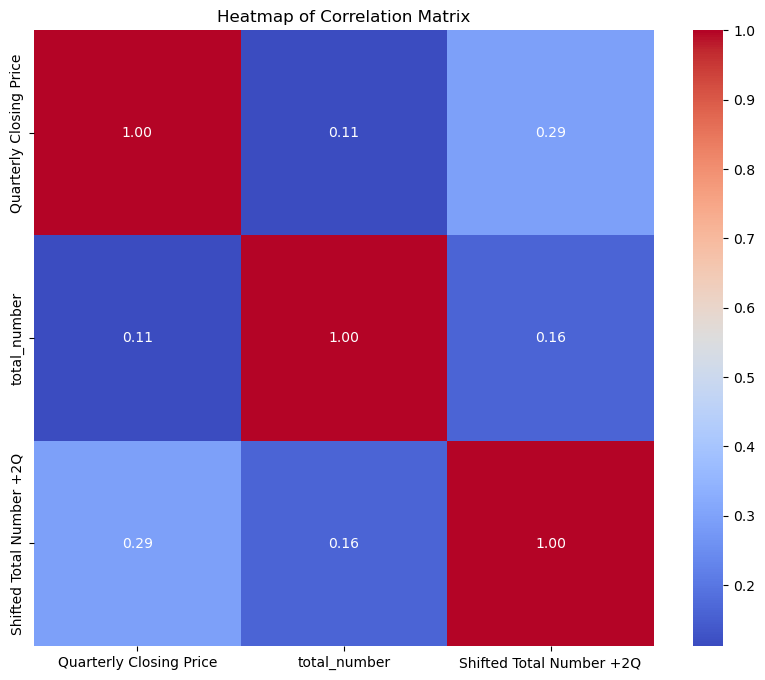

In [53]:
'''
Create a heatmap comparing the total number of shares from 13F filings for State Street, 
shifted down by two quarters, against State Street's stock data from Yahoo Finance.

'''

# Prepare data by adding the shifted column to the DataFrame
data_stt_new .loc[:, 'Shifted Total Number +2Q'] = data_stt_new['total_number'].shift(2)


# Selecting relevant columns for the heatmap
heatmap_data = data_stt_new[['Quarterly Closing Price', 'total_number', 'Shifted Total Number +2Q']]

# Dropping NA values for a clean heatmap
heatmap_data = heatmap_data.dropna()

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [60]:
# Merge Blackrock stock data from Yahoo Finance with 13F filings 


# Load the combined dataframe
df_correlation = df_com_top.copy()
df_correlation = df_correlation.loc[df_correlation['CIK'] == 1364742]
df_correlation = df_correlation.groupby(['FILINGMANAGER_NAME', 'filing_quarter']).agg(
    total_value=('VALUE', 'sum'),  # Sum of VALUE for each group
    total_number=('SSHPRNAMT', 'sum'), 
).reset_index()

# Function to convert quarter string to end of quarter date
def convert_quarter_to_accurate_date(quarter_str):
    year, quarter = quarter_str.split('q')
    if quarter == '1':
        month = 3  # Q1 ends in March
        day = 31
    elif quarter == '2':
        month = 6  # Q2 ends in June
        day = 30
    elif quarter == '3':
        month = 9  # Q3 ends in September
        day = 30
    else:
        month = 12  # Q4 ends in December
        day = 31
    return f"{year}-{month}-{day}"

df_correlation['filing_quarter'] = df_correlation['filing_quarter'].apply(convert_quarter_to_accurate_date)
df_correlation['filing_quarter'] = pd.to_datetime(df_correlation['filing_quarter'])

# Assuming the STT.csv file has been uploaded and is accessible
data = pd.read_csv('/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/BLK.csv')  # Update the path as necessary
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Resample the data to get the adjusted close price at the end of each quarter
quarterly_prices_BLK = data['Adj Close'].resample('Q').ohlc()[['open', 'close']]
quarterly_prices_BLK ['Quarterly Return'] = (quarterly_prices_BLK ['close'] - quarterly_prices_BLK ['open']) / quarterly_prices_BLK ['open']
quarterly_prices_BLK  = quarterly_prices_BLK .reset_index()
quarterly_prices_BLK.rename(columns={'close': 'Quarterly Closing Price', 'Date': 'filing_quarter'}, inplace=True)

# Merging the quarterly stock prices and returns with the df_correlation2 DataFrame
df_BLK_correlation_merge = pd.merge(df_correlation, quarterly_prices_BLK [['filing_quarter', 'Quarterly Closing Price', 'Quarterly Return']],
                                            on='filing_quarter', how='left')

# Calculate the percentage change for the specified columns
df_BLK_correlation_merge['Change in Quarterly Closing Price'] = df_BLK_correlation_merge['Quarterly Closing Price'].pct_change()
df_BLK_correlation_merge['Change in Total Value'] = df_BLK_correlation_merge['total_value'].pct_change()
df_BLK_correlation_merge['Change in Total Number'] = df_BLK_correlation_merge['total_number'].pct_change()

# Display the merged DataFrame
df_BLK_correlation_merge.head()



/var/folders/ww/8cnk8cbj1j56c7zdw6nvqfjc0000gn/T/ipykernel_29240/2673452727.py:34: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,FILINGMANAGER_NAME,filing_quarter,total_value,total_number,Quarterly Closing Price,Quarterly Return,Change in Quarterly Closing Price,Change in Total Value,Change in Total Number
0,BlackRock Inc.,2014-03-31,13103118,123123906,243.993591,0.011727,NaN,<NA>,<NA>
1,BlackRock Inc.,2014-06-30,12948129,125988928,249.515671,0.014855,0.022632,-0.011828,0.023269
2,BlackRock Inc.,2014-09-30,13316643,141043405,257.815277,0.024353,0.033263,0.028461,0.11949
3,BlackRock Inc.,2014-12-31,14016325,142233449,282.293427,0.112153,0.094945,0.052542,0.008437
4,BlackRock Inc.,2015-03-31,14679598,141498734,290.525574,0.031556,0.029162,0.047321,-0.005166


In [61]:
''' 
Calculate the correlation between the total number of shares from 13F filings for Blackrock
and Blackrock's stock data from Yahoo Finance, adjusting for quarterly shifts to assess if 
the correlation strengthens.
'''

data_new_BLK =df_BLK_correlation_merge

# Trying different shifts on 'total_number' and calculating the correlation with 'Quarterly Closing Price'
shift_correlations_new = {}
for i in range(-8, 9):  # Check from 8 quarters back to 8 quarters forward
    shifted_col = data_new_BLK ['total_number'].shift(i)
    correlation = shifted_col.corr(data_new_BLK ['Quarterly Closing Price'])
    shift_correlations_new[i] = correlation

# Finding the shift with the highest positive correlation
best_shift_new = max(shift_correlations_new, key=shift_correlations_new.get)
best_correlation_new = shift_correlations_new[best_shift_new]

best_shift_new, best_correlation_new


(0, 0.8616972047980719)

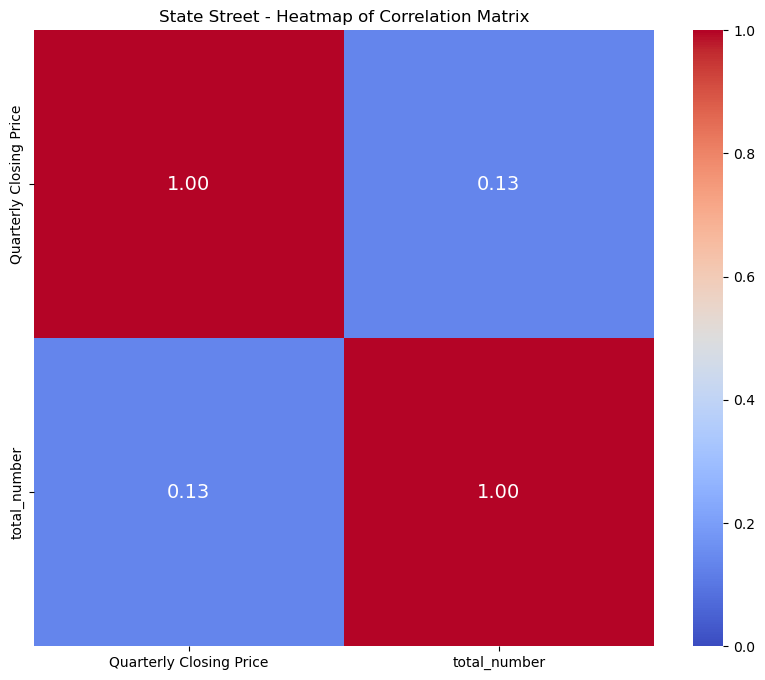

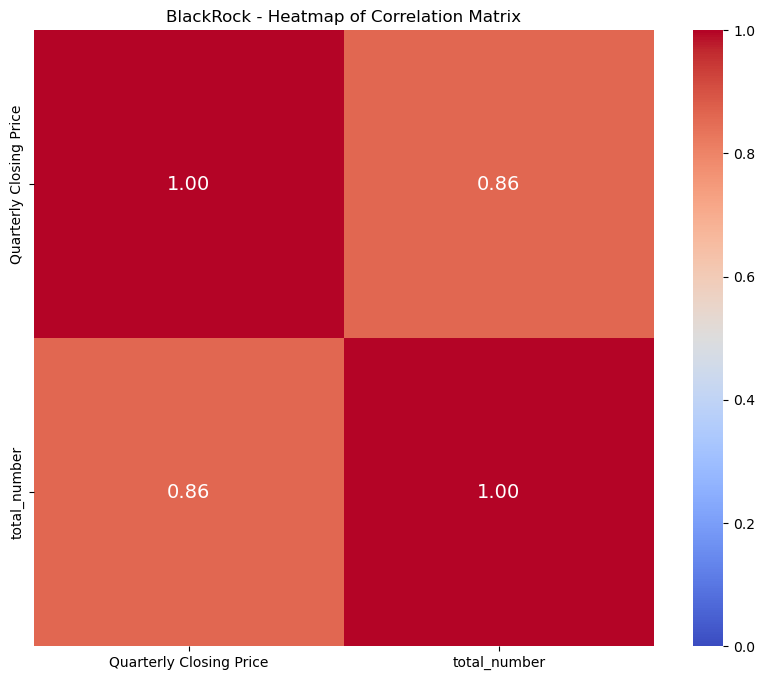

In [64]:
'''
Create a heatmap comparing the total number of shares from 13F filings for State street, 
against State street's stock data from Yahoo Finance.
'''
# Selecting and cleaning data
heatmap_data_stt = data_stt_new[['Quarterly Closing Price', 'total_number']].dropna()

# Creating the heatmap with a consistent color scale
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_stt.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 14}, vmin=0, vmax=1)
plt.title('State Street - Heatmap of Correlation Matrix')
plt.show()

'''
Create a heatmap comparing the total number of shares from 13F filings for BlackRock, 
against Blackrock's stock data from Yahoo Finance.
'''

# Selecting and cleaning data
heatmap_data_blk = data_new_BLK[['Quarterly Closing Price', 'total_number']].dropna()

# Creating the heatmap with a consistent color scale
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_blk.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 14}, vmin=0, vmax=1)
plt.title('BlackRock - Heatmap of Correlation Matrix')
plt.show()


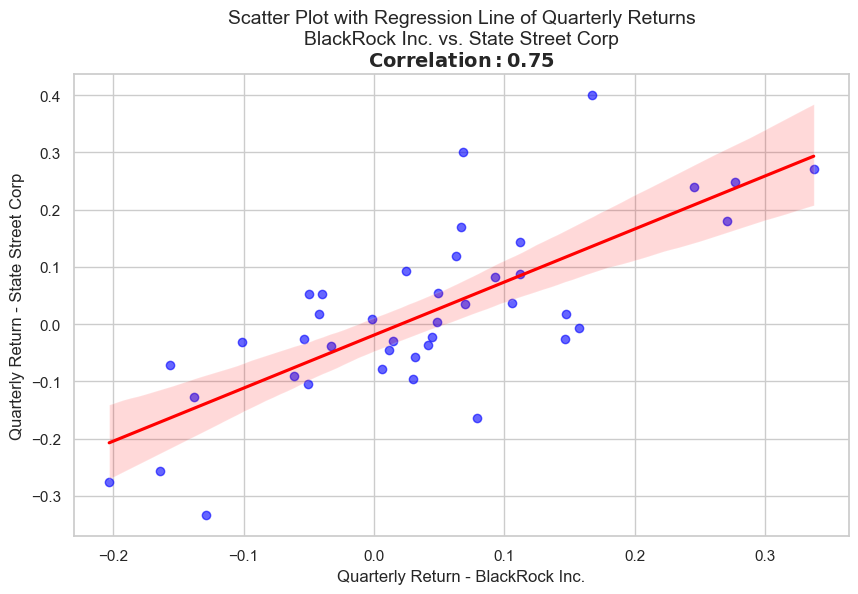

In [65]:
'''
Correlations between blackrock quarterly return and Statestreet quarterly return
'''


# Assuming 'data_new_BLK' and 'data_stt_new' are pre-defined datasets
blk_data = data_new_BLK
stt_data = data_stt_new

# Format the 'filing_quarter' to datetime for both datasets
blk_data['filing_quarter'] = pd.to_datetime(blk_data['filing_quarter'])
stt_data['filing_quarter'] = pd.to_datetime(stt_data['filing_quarter'], errors='coerce')

# Merge the datasets on the 'filing_quarter'
merged_data = pd.merge(
    blk_data[['filing_quarter', 'Quarterly Return']],
    stt_data[['filing_quarter', 'Quarterly Return']],
    on='filing_quarter',
    suffixes=('_BLK', '_STT')
)

# Calculate the correlation between the 'Quarterly Return' of both datasets
correlation = merged_data['Quarterly Return_BLK'].corr(merged_data['Quarterly Return_STT'])

# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
scatter_plot = sns.regplot(
    x='Quarterly Return_BLK',
    y='Quarterly Return_STT',
    data=merged_data,
    scatter_kws={'alpha':0.6, 'color':'blue'},
    line_kws={'color':'red'}
)

# Setting plot title and labels
plt.title(f'Scatter Plot with Regression Line of Quarterly Returns\nBlackRock Inc. vs. State Street Corp\n$\mathbf{{Correlation: {correlation:.2f}}}$', fontsize=14)
plt.xlabel('Quarterly Return - BlackRock Inc.')
plt.ylabel('Quarterly Return - State Street Corp')

# Display the plot
plt.show()


In [ ]:
# Import and concatenate all 13F ZIP files from 2014 to 2024, filtering for relevant columns 


start_year = 2014
end_year = 2023
quarters = [f"{year}q{quarter}" for year in range(start_year, end_year + 1) for quarter in range(1, 5)]
quarters.append("2024q1")


merged_dfs=[]


top_15_stocks=flattened_list

for quarter in quarters:
    df_cov = pd.read_csv(f"/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/{quarter}_form13f/COVERPAGE.tsv", sep='\t',
                         usecols=['ACCESSION_NUMBER', 'REPORTCALENDARORQUARTER', 'FILINGMANAGER_NAME','ISAMENDMENT','AMENDMENTTYPE'])
    df_sub = pd.read_csv(f"/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/{quarter}_form13f/SUBMISSION.tsv", sep='\t',
                         usecols=['ACCESSION_NUMBER','CIK','FILING_DATE', 'SUBMISSIONTYPE'])
    df_info = pd.read_csv(f"/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/{quarter}_form13f/INFOTABLE.tsv", 
                          sep='\t',usecols=['ACCESSION_NUMBER','INFOTABLE_SK','NAMEOFISSUER','NAMEOFISSUER',
                                          'TITLEOFCLASS','CUSIP','VALUE','SSHPRNAMT','SSHPRNAMTTYPE'],
                          dtype={'ACCESSION_NUMBER':'string','INFOTABLE_SK':'Int32','NAMEOFISSUER':'string','NAMEOFISSUER':'string',
                                          'TITLEOFCLASS':'string','CUSIP':'string','FIGI':'float','VALUE':'Int64','SSHPRNAMT':'Int32','SSHPRNAMTTYPE':'string'})


    
    #merge coverpage and info q1 2024
    df_combine=df_cov.merge(df_info, how='right', on ='ACCESSION_NUMBER')
    df_combine=df_sub.merge(df_combine, how='right', on ='ACCESSION_NUMBER')
   
    #add 
    df_combine['filing_quarter']=quarter
    merged_dfs.append(df_combine)

        
#concat q1 2024 and q4 2023
df_combine=pd.concat(merged_dfs)
del merged_dfs

In [ ]:
#save merged file
df_combine.to_pickle('/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/combine_data.pkl')

In [4]:
#load merged file
df_combine=pd.read_pickle('/Users/joyzhang/Desktop/data2024/DatascienceAcademy/PythonProject/combine_data.pkl')

In [5]:
#Find managers who invested in Crypto
# Define a list of keywords related to cryptocurrency investments
keywords = [
    "Grayscale", "Bitwise",  # Cryptocurrency Trusts and Funds
    "Coinbase", "Riot Blockchain", "Marathon Digital", "MicroStrategy",  # Blockchain and Crypto Companies
    "Bitcoin ETF", "Crypto ETF", "Blockchain ETF", "BLOK", "LEGR", "BKCH",  # ETFs and Related Products
    "Bitcoin", "Ethereum", "Blockchain"  # Specific Crypto Assets and Technologies
]

# Create a regex pattern to match any of the keywords (case insensitive)
pattern = '|'.join(keywords)  # Joins all keywords into a single string separated by '|'

# Filter the DataFrame for rows where 'NAMEOFISSUER' contains any of the keywords
df_crypto = df_combine[df_combine['NAMEOFISSUER'].str.contains(pattern, case=False, na=False)]


df_crypto_reorg=df_crypto.sort_values(by='VALUE', ascending=False).groupby(['FILINGMANAGER_NAME','filing_quarter']).agg(
    total_value=('VALUE', 'sum'),
).reset_index().sort_values(by='total_value', ascending=False)



<Figure size 3000x1000 with 0 Axes>

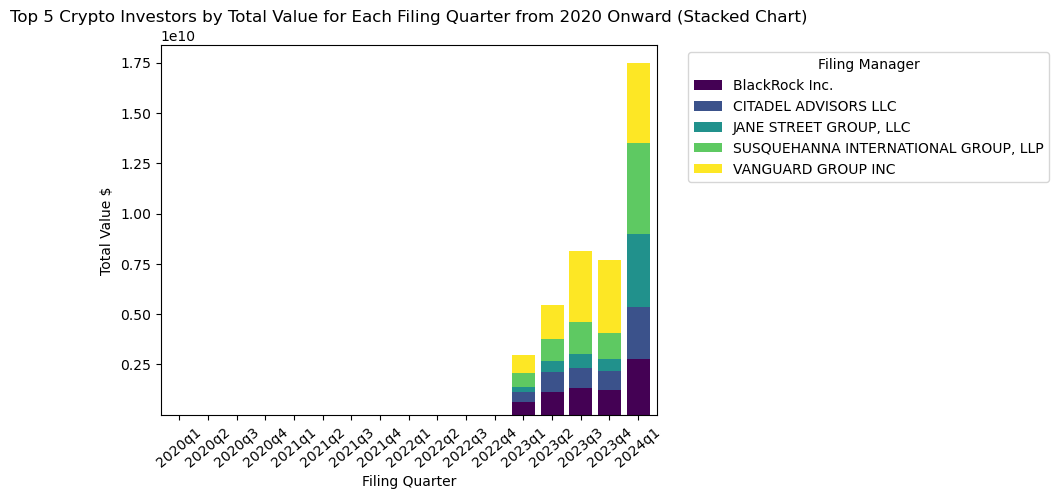

In [6]:
#Top 5 Crypto Investors by Total Value for Each Filing Quarter from 2020 Onward (Stacked Chart)

# First, identify the overall top 5 filing managers based on total value across all quarters
top_5_investors = df_crypto_reorg.loc[df_crypto_reorg['filing_quarter']=='2024q1'].groupby('FILINGMANAGER_NAME')['total_value'].sum().nlargest(5).index

# Filter the data to include only these top 5 investors
filtered_data = df_crypto_reorg[df_crypto_reorg['FILINGMANAGER_NAME'].isin(top_5_investors)]
# Group the filtered data by 'filing_quarter' and 'FILINGMANAGER_NAME', summing up 'total_value'
top_5_investors_data = filtered_data.groupby(['filing_quarter', 'FILINGMANAGER_NAME']).sum().unstack(fill_value=0)
# Filter the data to only include quarters starting from 2020
top_5_investors_data_2020_onward = top_5_investors_data[top_5_investors_data.index >= '2020q1']


# Increase the figure width for a larger display
plt.figure(figsize=(30, 10)) 
top_5_investors_data_2020_onward.plot(kind='bar', stacked=True, colormap='viridis',width=0.8)
plt.title('Top 5 Crypto Investors by Total Value for Each Filing Quarter from 2020 Onward (Stacked Chart)')
plt.xlabel('Filing Quarter')
plt.ylabel('Total Value $')
plt.xticks(rotation=40)
plt.legend(title='Filing Manager', labels=[name[1] for name in top_5_investors_data.columns], bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()
plt.show()



In [8]:
#Find managers who invested in Cannabis
# Define a list of keywords related to cannabis investments
keywords1 = [
    'Cannabis', 'Curaleaf','Green Thumb',
    'Innovative Industrial',
    'Trulieve Cannabis' ,
    'Verano Holdings' ,
    'Cresco Labs',
    'Emerald Holding'
]

# Create a regex pattern to match any of the keywords (case insensitive)
pattern = '|'.join(keywords1)  # Joins all keywords into a single string separated by '|'

# Filter the DataFrame for rows where 'NAMEOFISSUER' contains any of the keywords

df_Cannabis = df_combine[
    (df_combine['NAMEOFISSUER'].str.contains(pattern, case=False, na=False)) |
    (df_combine['TITLEOFCLASS'].str.contains('Cannabis', case=False, na=False))
]


df_Cannabis_reorg=df_Cannabis.sort_values(by='VALUE', ascending=False).groupby(['FILINGMANAGER_NAME','filing_quarter']).agg(
    total_value=('VALUE', 'sum'),
).reset_index()


<Figure size 5000x2000 with 0 Axes>

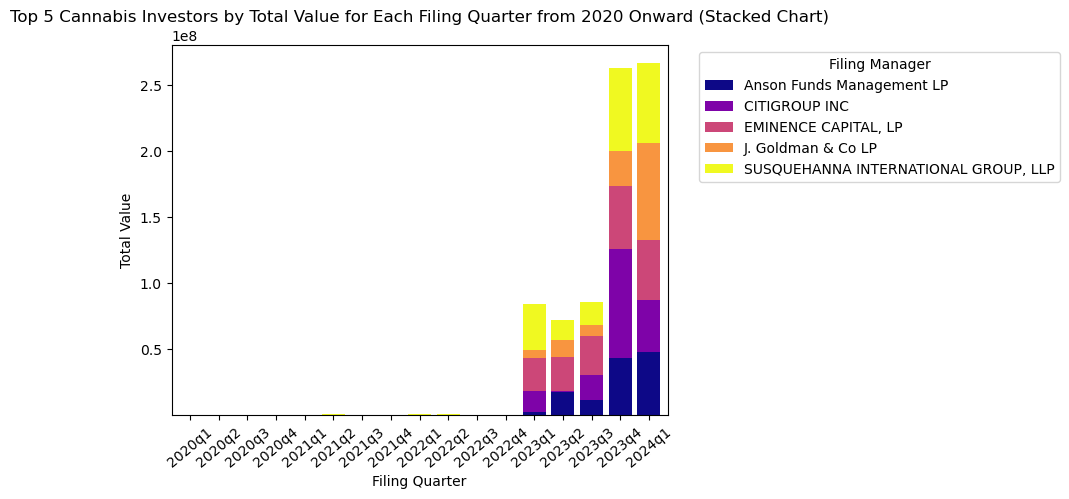

In [15]:
#Top 5 Cannabis Investors by Total Value for Each Filing Quarter from 2020 Onward (Stacked Chart)

# First, identify the overall top 5 filing managers based on total value across all quarters
top_5_investors_c = df_Cannabis_reorg.loc[df_Cannabis_reorg['filing_quarter']=='2024q1'].groupby('FILINGMANAGER_NAME')['total_value'].sum().nlargest(5).index

# Filter the data to include only these top 5 investors
filtered_data_c = df_Cannabis_reorg[df_Cannabis_reorg['FILINGMANAGER_NAME'].isin(top_5_investors_c)]
# Group the filtered data by 'filing_quarter' and 'FILINGMANAGER_NAME', summing up 'total_value'
top_5_investors_data_c = filtered_data_c.groupby(['filing_quarter', 'FILINGMANAGER_NAME']).sum().unstack(fill_value=0)
# Filter the data to only include quarters starting from 2020
top_5_investors_data_2020_onward_c = top_5_investors_data_c[top_5_investors_data_c.index >= '2020q1']

# Increase the figure width for a larger display
plt.figure(figsize=(50, 20))
top_5_investors_data_2020_onward_c.plot(kind='bar', stacked=True, colormap='plasma', width=0.8)
plt.title('Top 5 Cannabis Investors by Total Value for Each Filing Quarter from 2020 Onward (Stacked Chart)')
plt.xlabel('Filing Quarter')
plt.ylabel('Total Value')
plt.xticks(rotation=40)
plt.legend(title='Filing Manager', labels=[name[1] for name in top_5_investors_data_c.columns], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

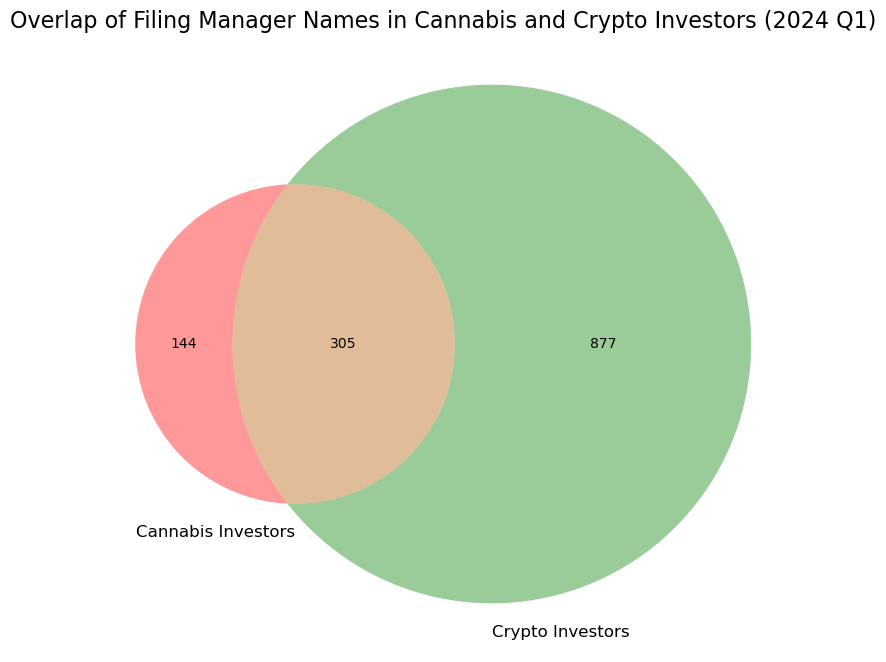

In [13]:
#Venn Diagram Overlap of Filing Manager Names in Cannabis and Crypto Investors
# Load the datasets
cannabis_data = df_Cannabis_reorg
crypto_data =df_crypto_reorg
# Filter data for "2024q1" in both datasets under 'filing_quarter'
cannabis_2024q1 = cannabis_data[cannabis_data['filing_quarter'] == '2024q1']
crypto_2024q1 = crypto_data[crypto_data['filing_quarter'] == '2024q1']

# Extract the unique FILINGMANAGER_NAME and corresponding total_value sums for both filtered datasets
cannabis_managers = cannabis_2024q1.groupby('FILINGMANAGER_NAME')['total_value'].sum().reset_index()
crypto_managers = crypto_2024q1.groupby('FILINGMANAGER_NAME')['total_value'].sum().reset_index()

# Get sets of FILINGMANAGER_NAME for both datasets
cannabis_managers_set = set(cannabis_managers['FILINGMANAGER_NAME'])
crypto_managers_set = set(crypto_managers['FILINGMANAGER_NAME'])

# Plotting the Venn diagram
plt.figure(figsize=(10, 8))
venn2([cannabis_managers_set, crypto_managers_set], ('Cannabis Investors', 'Crypto Investors'))
plt.title('Overlap of Filing Manager Names in Cannabis and Crypto Investors (2024 Q1)',fontsize=16)
plt.show()